# chapter7-2


## 要約生成の評価指標

### ライブラリのインストール

In [ ]:
!pip install mecab-python3 rouge-score sacrebleu bert_score ipadic datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 50.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)

### ROUGE

生成文と参照文の一致度を測る

参照文に含まれる語句がモデルの生成文の中にどれほど含まれているかを重視

ただし生成文を長くしすぎると評価の値が高くなってしまい、適切な評価が行えないこともある。

$\rightarrow$F値を算出して評価をすることも多い

In [ ]:
reference = "日本語T5モデルの公開"
prediction1 = "T5モデルの日本語版を公開"
prediction2 = "日本語T5をリリース"
prediction3 = "Japanese T5を発表"

### 各文を単語単位に分割

In [ ]:
import ipadic
import MeCab

# 単語分割を行う
tagger = MeCab.Tagger(f"-O wakati {ipadic.MECAB_ARGS}")
ref_wakati = tagger.parse(reference).strip()
pred1_wakati = tagger.parse(prediction1).strip()
pred2_wakati = tagger.parse(prediction2).strip()
pred3_wakati = tagger.parse(prediction3).strip()


In [ ]:
# 分割したものを表示
print(f"参照文: {ref_wakati}")
print(f"生成文1: {pred1_wakati}")
print(f"生成文2: {pred2_wakati}")
print(f"生成文3: {pred3_wakati}")

参照文: 日本語 T 5 モデル の 公開
生成文1: T 5 モデル の 日本語 版 を 公開
生成文2: 日本語 T 5 を リリース
生成文3: Japanese T 5 を 発表


### ROUGEの算出

In [ ]:
from collections import defaultdict
import pandas as pd
from datasets import load_metric

# 小数点以下の桁数を3に設定
pd.options.display.precision = 3

def convert_words_to_ids(
    predictions: list[str], reference: list[str]
) -> tuple[list[str], list[str]]:
  """ 単語列をID列に変換 """

  # 単語にユニークなIDを割り当てるためのdefaultdictを作成する
  word2id = defaultdict(lambda: len(word2id))

  # 単語区切りの文字列をID文字列に変換
  pred_ids = [
      " ".join([str(word2id[w]) for w in p.split()])
      for p in predictions
  ]

  ref_ids = [
      " ".join([str(word2id[w]) for w in r.split()])
      for r in reference
  ]

  return pred_ids, ref_ids

def compute_rouge(
    predictions: list[str], reference: list[str]
) -> dict[str, dict[str, float]]:
  """ ROUGEを算出 """

  # ROUGEをロード
  rouge = load_metric("rouge")

  # 単語列をID列に変換
  pred_ids, ref_ids = convert_words_to_ids(predictions, reference)

  # 単語ID列を評価対象に加える
  rouge.add_batch(predictions=pred_ids, references=ref_ids)

  # スコアの計算
  scores = rouge.compute(rouge_types=["rouge1", "rouge2", "rougeL"])

  return {k: v.mid for k, v in scores.items()}

# ROUGEを計算した結果を表示
rouge_results = {
    "text1": compute_rouge([pred1_wakati], [ref_wakati]),
    "text2": compute_rouge([pred2_wakati], [ref_wakati]),
    "text3": compute_rouge([pred3_wakati], [ref_wakati])
}

df_list = [
    pd.DataFrame.from_dict(rouge_results[k], orient="index")
    for k in rouge_results.keys()
]

display(pd.concat(df_list, keys=rouge_results.keys(), axis=1).T)

<ipython-input-5-7c5733c4f336>:35: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

rouge1  rouge2  rougeL
text1 precision   0.750   0.429   0.625
      recall      1.000   0.600   0.833
      fmeasure    0.857   0.500   0.714
text2 precision   0.600   0.500   0.600
      recall      0.500   0.400   0.500
      fmeasure    0.545   0.444   0.545
text3 precision   0.400   0.250   0.400
      recall      0.333   0.200   0.333
      fmeasure    0.364   0.222   0.364

### BLEUを算出

In [ ]:
def compute_bleu(
    predictions: list[str], reference: list[str]
) -> dict[str, int | float | list[float]]:
  """ BLEUを算出 """

  # sacreBLEUをロード
  bleu = load_metric("sacrebleu")

  # 単語列を評価対象に加える
  bleu.add_batch(predictions=predictions, references=reference)

  # BLEUを計算
  results = bleu.compute()
  results["precisions"] = [
      round(p, 2) for p in results["precisions"]
  ]

  return results

# BLEUを計算した結果を表示
bleu_results = {
    "text1": compute_bleu([pred1_wakati], [[ref_wakati]]),
    "text2": compute_bleu([pred2_wakati], [[ref_wakati]]),
    "text3": compute_bleu([pred3_wakati], [[ref_wakati]])
}

df_list = [
    pd.DataFrame.from_dict(bleu_results[k], orient="index")[0]
    for k in bleu_results.keys()
]

print(df_list)

display(pd.concat(df_list, keys=bleu_results.keys(), axis=1).T)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

[score                              38.26
counts                      [6, 3, 2, 1]
totals                      [8, 7, 6, 5]
precisions    [75.0, 42.86, 33.33, 20.0]
bp                                   1.0
sys_len                                8
ref_len                                6
Name: 0, dtype: object, score                            32.556
counts                     [3, 2, 1, 0]
totals                     [5, 4, 3, 2]
precisions    [60.0, 50.0, 33.33, 25.0]
bp                                0.819
sys_len                               5
ref_len                               6
Name: 0, dtype: object, score                            17.492
counts                     [2, 1, 0, 0]
totals                     [5, 4, 3, 2]
precisions    [40.0, 25.0, 16.67, 12.5]
bp                                0.819
sys_len                               5
ref_len                               6
Name: 0, dtype: object]


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


,score,counts,totals,precisions,bp,sys_len,ref_len
text1,38.26,"[6, 3, 2, 1]","[8, 7, 6, 5]","[75.0, 42.86, 33.33, 20.0]",1.0,8,6
text2,32.556,"[3, 2, 1, 0]","[5, 4, 3, 2]","[60.0, 50.0, 33.33, 25.0]",0.819,5,6
text3,17.492,"[2, 1, 0, 0]","[5, 4, 3, 2]","[40.0, 25.0, 16.67, 12.5]",0.819,5,6


### BERTScore

/usr/local/lib/python3.10/dist-packages/bert_score/score.py:316: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/bert_score/score.py:316: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/bert_score/score.py:316: UserWarning: Glyph 35486 (\N{CJK UNIFIED IDEOGRAPH-8A9E}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/bert_score/score.py:316: UserWarning: Glyph 12514 (\N{KATAKANA LETTER MO}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/bert_score/score.py:316: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/bert_score/score.py:316: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from current font.
  fig.tight_layout(

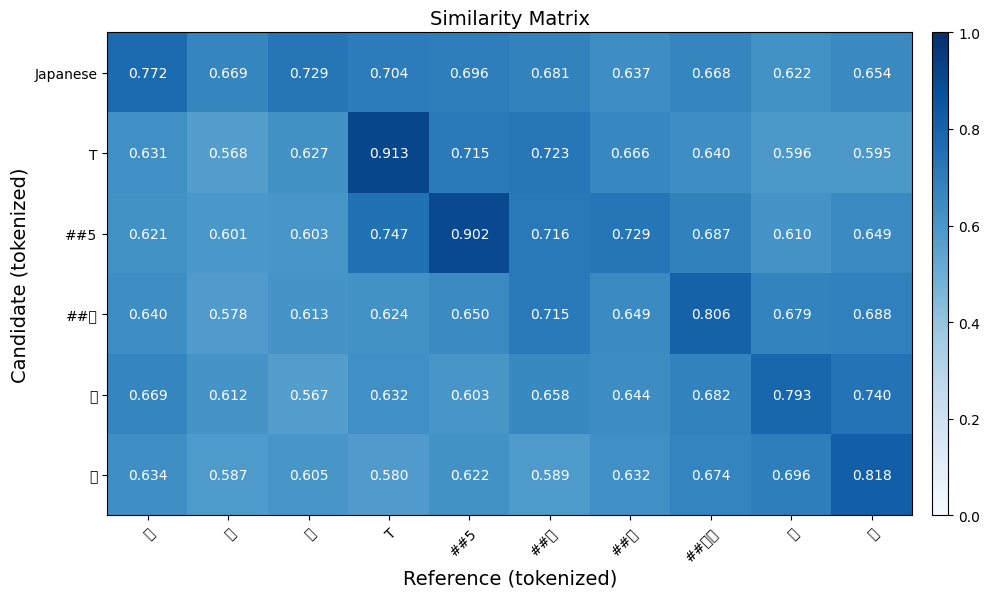

In [ ]:
from bert_score import plot_example

# 生成文3と参照文の類似度行列を作成
plot_example(prediction3, reference, lang="ja")

In [ ]:
def compute_bertscore(
    predictions: list[str], references: list[str]
) -> dict[str, float]:
  """ BERTScoreの算出 """

  # BERTScoreのロード
  bertscore = load_metric("bertscore")

  # 評価対象に追加
  bertscore.add_batch(
      predictions=predictions, references=references
  )

  # BERTScoreを計算
  results = bertscore.compute(lang="ja")

  return {
      k: sum(v) / len(v)
      for k, v in results.items()
      if k != "hashcode"
  }

# BERTScoreを算出した結果を表示
bertscore_results = {
    "text1": compute_bertscore([prediction1], [reference]),    # 関数内部でトークナイゼーションをするため文字列のまま入力
    "text2": compute_bertscore([prediction2], [reference]),
    "text3": compute_bertscore([prediction3], [reference])
}

df_list = [
    pd.DataFrame.from_dict(bertscore_results[k], orient="index")[0]
    for k in bertscore_results.keys()
]

display(pd.concat(df_list, keys=bertscore_results.keys(), axis=1).T)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this m

,precision,recall,f1
text1,0.877,0.903,0.890
text2,0.879,0.824,0.850
text3,0.834,0.785,0.809
